# Class 4: The Bias-Variance Trade-off

**Big idea:** More complex models aren't always better. The best model balances *accuracy* (low bias) with *stability* (low variance).

Today we will:
- Understand bias and variance through **simulation** (not just formulas)
- See why simple models can outperform complex ones
- Recap **regularization** (Lasso) as a tool to reduce variance

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

prng = np.random.RandomState(20260225)

%precision 3
pd.set_option('display.precision', 3)

## Why do simple models sometimes win?

In the previous class on clustering, we saw that adding more features doesn't always help (curse of dimensionality). Here we'll discover a related phenomenon: **adding more complexity to our model doesn't always help either**.

Consider this puzzle: If we know the true relationship is quadratic ($Y = X^2 - 1.5X + \varepsilon$), shouldn't a quadratic model always outperform a linear one?

**Spoiler:** Not necessarily! Let's understand why through the **bias-variance decomposition**.

### The Setup

Suppose the true relationship between $X$ and $Y$ is:

$$
Y = f(X) + \varepsilon
$$

where $f(X)$ is some unknown function and $\varepsilon$ is random noise with $E[\varepsilon] = 0$.

Our goal is to estimate $\hat{f}(X)$ from data. **Different training samples give us different $\hat{f}$**. So $\hat{f}$ is itself a random variable!

### The Key Question

When we make a prediction $\hat{f}(X)$, how far off will we be on average?

The **Mean Squared Error (MSE)** measures this:

$$
MSE = E\left[\left(Y - \hat{f}(X)\right)^2\right]
$$

It turns out this error can be decomposed into three parts:

$$
MSE = \underbrace{\text{Bias}^2}_{\text{systematic error}} + \underbrace{\text{Variance}}_{\text{sensitivity to data}} + \underbrace{\sigma^2_\varepsilon}_{\text{irreducible noise}}
$$

- **Bias**: How far off is our model *on average*? (Does it systematically miss the target?)
- **Variance**: How much does our model *change* with different training data? (Is it stable?)
- **Irreducible error**: Random noise we can never predict

*Question:* Why is it called "irreducible error"?

<details>
<summary>Answer</summary>

No matter how perfect our model becomes, we cannot reduce prediction error to zero. This remaining 'irreducible error' exists because real-world data contains inherent randomness and unmeasured variables that influence outcomes. These unpredictable elements represent the fundamental noise in any system that no model can capture.

</details>

</br>

#### Math detour: bias-variance decomposition

To prove the statement above, let's decompose the expected prediction error:

$$
\begin{align*}
    E\left[\left(Y - \hat{f}(X)\right)^2\right] &= E\left[\left(f(X) + \varepsilon - \hat{f}(X)\right)^2\right] \\
        &= E\left[\left(f(X) - \hat{f}(X)\right)^2\right] + 2E\left[\varepsilon(f(X) - \hat{f}(X))\right] + E\left[\varepsilon^2\right] \\
        &= E\left[\left(f(X) - \hat{f}(X)\right)^2\right] + 2\underbrace{E[\varepsilon]}_{=0}E\left[f(X) - \hat{f}(X)\right] + E\left[\varepsilon^2\right] \\
        &= E\left[\left(f(X) - E[\hat{f}(X)] + E[\hat{f}(X)] - \hat{f}(X)\right)^2\right] + E\left[\varepsilon^2\right] \\
        &= E\left[\left(f(X) - E[\hat{f}(X)]\right)^2\right] + 2\underbrace{E\left[\left(f(X) - E[\hat{f}(X)]\right)\left(E[\hat{f}(X)] - \hat{f}(X)\right)\right]}_{=f(x)\left(E[\hat{f}(X)] - E[\hat{f}(X)]\right) - E[\hat{f}(X)]^2 + E[\hat{f}(X)]^2 = 0} + E\left[\left(E[\hat{f}(X)] - \hat{f}(X)\right)^2\right] + E\left[\varepsilon^2\right] \\    
        &= \left(\underbrace{f(X) - E[\hat{f}(X)]}_{\text{Bias}} \right)^2 + \underbrace{E\left[\left(E[\hat{f}(X)] - \hat{f}(X)\right)^2\right]}_{\text{Variance}} + \underbrace{E\left[\varepsilon^2\right]}_{\text{Irreducible error}}
\end{align*}
$$

Thus, MSE = Squared Bias + Variance + Irreducible error.

## Seeing bias-variance in action: Linear vs. Quadratic model

Let's *see* the trade-off through simulation. We'll compare two models:

1. **Simple model** (linear): $\hat{f}(X) = \beta_0 + \beta_1 X$ — *wrong* but stable
2. **Complex model** (quadratic): $\hat{f}(X) = \beta_0 + \beta_1 X + \beta_2 X^2$ — *correct* but more variable

### The true relationship

We'll generate data from a quadratic function with noise:

$$
Y = f(X) + \varepsilon = X^2 - 1.5 X + \varepsilon, \quad \varepsilon \sim N(0, 1)
$$

The quadratic model can represent the true relationship perfectly (zero bias), while the linear model cannot (non-zero bias). But which performs better in practice?

### Data generating process

Below we define:
- `trueModel(x)`: the true function $f(X) = X^2 - 1.5X$
- `generateData()`: generates samples with random $X$ values and adds noise to create observed $Y$

In [46]:
def trueModel(x):
    y = x**2 - 1.5*x
    return y

def generateData(prng, sample_size):
    x = prng.uniform(0, 1, size=sample_size)
    y_true = trueModel(x)
    y = y_true + prng.normal(0, 1, size=sample_size)

    feature_df = pd.DataFrame({'x': x})
    return feature_df, y

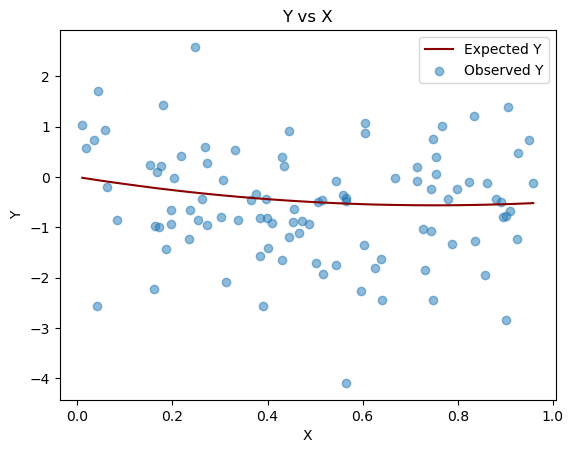

In [47]:
# Plot
features, y = generateData(prng, sample_size=100)

plt.plot(features['x'].sort_values(), trueModel(features['x'].sort_values()), label="Expected Y", color='darkred')
plt.scatter(features['x'], y, label="Observed Y", alpha=0.5)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Y vs X")
plt.legend()
plt.show()

### Evaluation point

To understand bias and variance, we need to evaluate our model at a specific point. We'll use $X_0 = 0.5$ (the middle of our range).

Since we know the true model, we know that:

$$
f(0.5) = 0.5^2 - 1.5 \times 0.5 = -0.5
$$

**Important:** In real ML problems, we don't know $f(X)$. That's why we use train-test splits. But in this simulation, knowing the truth lets us directly measure bias and variance.

In [48]:
# Evaluate the model's performance at a single point: X=0.5 (y = -0.5)
test_data = pd.DataFrame({'x': [0.5]})
trueModel(test_data['x'])[0]


-0.500

### Fitting two competing models

Now let's fit both a linear and quadratic model to the *same* data. We'll see how their predictions at $X_0 = 0.5$ differ.

#### Technical detour: pandas Dataframe vs Series

If `data` is a pandas Dataframe, then `data['x']` is a pandas Series. Pandas Series are like numpy arrays but with additional functionality.
If you would like to pass a Dataframe with a single column, you can use the `data[['x']]` syntax. (Think of it as the standard way of selecting columns from a Dataframe that you would do with  `data[list_of_columns]` syntax, e.g. `data[['x', 'y']]`. For a single column, this just collapses to `data[['x']]`.)
If you would like to get a scalar value, you should index it again. To get the first element (which could be the only element), you can use `data['x'][0]`.

Be careful with the different types of objects you get back. Some methods expect pandas Dataframes, others might expect scalars, or numpy arrays.

#### Linear model

We use `Pipeline` as you did in DA3. The usual `sklearn` syntax of definition -> fit -> transform/predict applies for pipelines as well. We will use our sample (`features`) to fit the models, and the middle point (`test_data`) for evaluation.

In [49]:
simple_model = Pipeline([("lm", LinearRegression())])
simple_model.fit(features, y)
simple_model.predict(test_data)

array([-0.554])

#### Quadratic model

In [50]:
squared_model = Pipeline([
    ("add-quadratic-term", PolynomialFeatures(degree=2, include_bias=False)),
    ("lm", LinearRegression())
])
squared_model.fit(features, y)

squared_model.predict(test_data)

array([-0.859])

## Monte Carlo simulation: The core experiment

One sample gives us one prediction. But to understand **bias** and **variance**, we need to see what happens across *many* different training samples.

**The idea:** If we could draw many independent training datasets from the same data generating process, we could:
- Estimate **bias** as the average deviation from the truth
- Estimate **variance** as how spread out our predictions are

This is exactly what a **Monte Carlo simulation** does: we repeatedly simulate the data-generating process and observe the distribution of outcomes.

### What is Monte Carlo simulation?

**Monte Carlo methods** use repeated random sampling to understand the behavior of systems that have randomness. Named after the famous casino, these methods "roll the dice" many times to see what typically happens.

In our context:
1. Generate a new random training dataset
2. Fit both models to this dataset
3. Record the predictions at $X_0 = 0.5$
4. Repeat 1000 times
5. Analyze the distribution of predictions

This lets us observe bias and variance directly, rather than just deriving them mathematically.

**Connection to econometrics:** This is similar to how you might simulate the sampling distribution of an estimator (e.g., showing that OLS is unbiased by simulating many samples).

In [51]:
# Set the number of Monte Carlo iterations and sample size
num_iterations = 1000
sample_size = 100

# Initialize arrays to store the results
predictions = np.empty((num_iterations, 2))

# Perform the Monte Carlo simulation
for i in range(num_iterations):

    features, y = generateData(prng, sample_size=sample_size)
    
    simple_fit = simple_model.fit(features, y)
    squared_fit = squared_model.fit(features, y)
    
    predictions[i, 0] = simple_model.predict(test_data)[0]
    predictions[i, 1] = squared_model.predict(test_data)[0]

In [52]:
# Summarize the results
pd.DataFrame({
    'model': ['simple', 'squared'],
    'x0': test_data['x'][0],
    'bias': np.mean(predictions - trueModel(test_data['x'])[0], axis=0),
    'variance': np.var(predictions, axis=0),
    'mse': np.mean(np.square(predictions - trueModel(test_data['x'])[0]), axis=0)
})


,model,x0,bias,variance,mse
0,simple,0.5,0.086,0.010,0.017
1,squared,0.5,0.003,0.023,0.023


### Interpreting the results

Look at the table above carefully:
- **Simple model**: Higher bias (wrong functional form), but lower variance (more stable)
- **Quadratic model**: Near-zero bias (correct functional form), but higher variance (more sensitive to data)

**The surprise:** Despite being "wrong," the simple model has lower MSE! It wins because its stability (low variance) more than compensates for its systematic error (bias).

*Question:* Which of the parameters (`num_iterations`, `sample_size`) should be changed to alter this result?

<details>
<summary>Answer</summary>

The `sample_size` parameter along with the implicit parameter of the variance of the noise term $\varepsilon$ together determine the **signal-to-noise ratio**. 

With larger samples, the true patterns become more distinguishable from random noise, which enables the complex model to benefit more from its accurate representation of the true relationship than what it loses on its higher variance. 

**Try it:** Re-run the simulation with `sample_size=500` and compare the results. The quadratic model should start winning!

</details>

### Visualizing the trade-off

To build intuition, we'll plot:
1. The **fitted functions** from many simulations (to see variance visually)
2. The **sampling distribution of coefficients** (to see how estimates vary)

A high-variance model produces wildly different predictions depending on which training data we happen to get.

Text(0.5, 1.0, 'Quadratic (n=1000)')

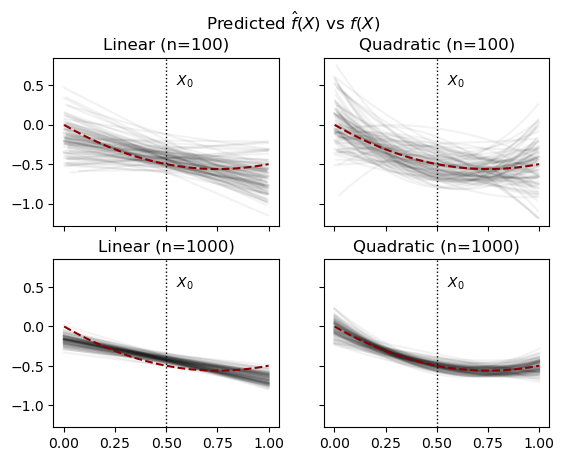

In [53]:
# Plot predictions
import matplotlib.pyplot as plt
import seaborn as sns

# Set the number of Monte Carlo iterations and sample size
num_iterations = 100
sample_sizes = [100, 1000]

# Initialize chart
fig, (axs) = plt.subplots(2, 2, sharey=True, sharex=True)

beta1_predictions = np.empty((num_iterations, 2, 2))

# Perform the Monte Carlo simulation
for i in range(num_iterations):

    for ids, s in enumerate(sample_sizes):
        features, y = generateData(prng, sample_size=s)

        simple_model = simple_model.fit(features, y)
        squared_model = squared_model.fit(features, y)

        simple_prediction = simple_model.predict(features.sort_values(by='x'))  # we need to sort them for the plot
        squared_prediction = squared_model.predict(features.sort_values(by='x'))
        
        beta1_predictions[i, ids, 0] = simple_model['lm'].coef_[0]
        beta1_predictions[i, ids, 1] = squared_model['lm'].coef_[0]

        axs[ids, 0].plot(features['x'].sort_values(), simple_prediction, color='black', alpha=0.05)
        axs[ids, 1].plot(features['x'].sort_values(), squared_prediction, color='black', alpha=0.05)

for ax in axs.flat:
    ax.plot(features['x'].sort_values(), trueModel(features['x'].sort_values()), color='darkred', linestyle='dashed')
    ax.axvline(x=0.5, ymin=0, ymax=1, linestyle="dotted", color="black", linewidth=1)
    ax.annotate(r"$X_0$", xy=(0.5, ax.get_ylim()[1]), xytext=(0.55, 0.5), fontsize=10)
    
fig.suptitle(r"Predicted $\hat{f}(X)$ vs $f(X)$")
axs[0, 0].set_title("Linear (n=100)")
axs[0, 1].set_title("Quadratic (n=100)")
axs[1, 0].set_title("Linear (n=1000)")
axs[1, 1].set_title("Quadratic (n=1000)")




Text(0.5, 1.0, 'Quadratic (n=1000)')

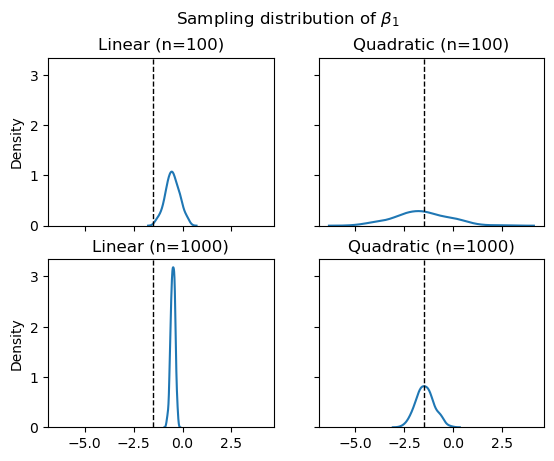

In [54]:
fig, (axs) = plt.subplots(2, 2, sharey=True, sharex=True)
for ax1 in range(2):
    for ax2 in range (2):
        s = sns.kdeplot(beta1_predictions[:, ax1, ax2], ax=axs[ax1, ax2])
        s.axvline(x=-1.5, ymin=0, ymax=1, linestyle="dashed", color="black", linewidth=1)

fig.suptitle(r"Sampling distribution of $\beta_1$")
axs[0, 0].set_title("Linear (n=100)")
axs[0, 1].set_title("Quadratic (n=100)")
axs[1, 0].set_title("Linear (n=1000)")
axs[1, 1].set_title("Quadratic (n=1000)")

**Interpreting the coefficient distributions:**
- The dashed line shows the true $\beta_1 = -1.5$
- **Linear model**: The distribution is tight (low variance) but not centered on -1.5 (biased)
- **Quadratic model**: The distribution is centered on -1.5 (unbiased) but more spread out (high variance)
- **Sample size effect**: With n=1000, both distributions tighten up, and the quadratic model's advantage becomes clearer

## Bias-variance in multidimensional problems

### New setup: Two predictors

Now we have:
$$
Y = X_1 + X_2 + \varepsilon, \quad \varepsilon \sim N(0, 2)
$$

Both predictors are relevant.

In [56]:
def trueModel(x1, x2):
    y = x1 + x2
    return y

def generateData(prng, sample_size):
    features = [prng.uniform(0, 1, size=sample_size) for _ in range(3)]
    y_true = trueModel(features[0], features[1])
    y = y_true + prng.normal(0, 2, size=sample_size) # sigma(epsilon) = 2
 
    feature_df = pd.DataFrame({
        'x1': features[0],
        'x2': features[1]
    })

    return feature_df, y


### Evaluation point

We'll evaluate at $(X_1, X_2) = (0, 0)$, where the true value is $f(0, 0) = 0$.

This is an **extrapolation point** (at the boundary of our data), which makes predictions more challenging and amplifies the variance problem.

In [57]:
# Evaluate the model's performance at a single point: X=0
test_data = pd.DataFrame({'x1': [0], 'x2': [0]})
trueModel(test_data['x1'], test_data['x2'])[0]

0

### Balancing between simple and complex: regularization

**Regularization** Use a complex model but *constrain* its flexibility to reduce variance.

#### From OLS to Lasso

You know OLS minimizes squared errors:
$$
\min_\beta \sum_i (Y_i - X_i'\beta)^2
$$

**Lasso** (Least Absolute Shrinkage and Selection Operator) adds a penalty on coefficient size:
$$
\min_\beta \sum_i (Y_i - X_i'\beta)^2 + \alpha \sum_j |\beta_j|
$$

The penalty term $\alpha \sum_j |\beta_j|$ does two things:
1. **Shrinks** coefficients toward zero (reduces variance)
2. **Selects** features by setting some coefficients exactly to zero (sparsity)

The penalty parameter $\alpha$ controls the trade-off:
  - $\alpha = 0$: identical to OLS (no penalty)
  - $\alpha \to \infty$: all coefficients shrunk to zero
  
**Key insight:** By accepting some bias (shrinking coefficients), we can substantially reduce variance.

### Fitting two competing models: OLS and Lasso

**Exercise:** Before looking at the code below, think about what you expect:
- Both models predict $\hat{f}(0, 0)$ when the true value is $f(0, 0) = 0$
- OLS has no penalty, Lasso has default $\alpha = 1.0$ (quite strong shrinkage)
- With only 20 observations and noise std = 2, how stable will each model be?

The code below fits both models and shows their predictions. Notice how the Lasso coefficients get shrunk.

In [67]:
sample_size = 20

X, y = generateData(prng, sample_size)

lm = LinearRegression().fit(X, y)
lasso = Lasso(random_state=prng).fit(X, y)

print("Linear model prediction: ", lm.predict(test_data)[0])
print("Lasso prediction: ", lasso.predict(test_data)[0])

Linear model prediction:  -0.6287015947942558
Lasso prediction:  0.7763334060450882


In [68]:
lasso.coef_

array([0., 0.])

In [61]:
?Lasso

Init signature:
Lasso(
    alpha=1.0,
    *,
    fit_intercept=True,
    precompute=False,
    copy_X=True,
    max_iter=1000,
    tol=0.0001,
    warm_start=False,
    positive=False,
    random_state=None,
    selection='cyclic',
)
Docstring:     
Linear Model trained with L1 prior as regularizer (aka the Lasso).

The optimization objective for Lasso is::

    (1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1

Technically the Lasso model is optimizing the same objective function as
the Elastic Net with ``l1_ratio=1.0`` (no L2 penalty).

Read more in the :ref:`User Guide <lasso>`.

Parameters
----------
alpha : float, default=1.0
    Constant that multiplies the L1 term, controlling regularization
    strength. `alpha` must be a non-negative float i.e. in `[0, inf)`.

    When `alpha = 0`, the objective is equivalent to ordinary least
    squares, solved by the :class:`LinearRegression` object. For numerical
    reasons, using `alpha = 0` with the `Lasso` object is not advised.

### Monte Carlo simulation: Lasso vs. OLS

Now we'll run another Monte Carlo simulation to compare:
- 1 OLS model (no penalty)
- 20 Lasso models with different penalty parameters $\alpha$


In [62]:
# Monte Carlo simulation

n_iterations = 1000
alphas_to_try = np.linspace(0.01, 0.5, num=20)

lm_predictions = np.empty(n_iterations)
lasso_predictions = np.empty((n_iterations, len(alphas_to_try)))
lasso_n_coeffs = np.empty((n_iterations, len(alphas_to_try)))

# Perform the Monte Carlo simulation
for i in range(n_iterations):

    X, y = generateData(prng, sample_size)

    lm_model = lm.fit(X, y)
    lm_predictions[i] = lm_model.predict(test_data)[0]

    for ida, a in enumerate(alphas_to_try):
        lasso_model = Lasso(alpha=a, random_state=prng).fit(X, y)
        lasso_predictions[i, ida] = lasso_model.predict(test_data)[0]
        lasso_n_coeffs[i, ida] = np.count_nonzero(lasso_model.coef_)  # we would like to count the non-zero coefficients

### Combining results

Linear Regression is a special case of Lasso with $\alpha = 0$. Let's concatenate the predictions for a unified analysis.

(*Note: `lm_predictions` is 1D, so we reshape it to 2D with `reshape(-1, 1)` before concatenation.*)

In [63]:
predictions = np.concatenate([lm_predictions.reshape(-1, 1), lasso_predictions], axis=1)
predictions.shape

(1000, 21)

In [64]:
alphas = np.concatenate([[0], alphas_to_try])
biases = np.mean(predictions - trueModel(test_data['x1'], test_data['x2'])[0], axis=0)
variances = np.var(predictions, axis=0)
mses = np.mean(np.square(predictions - trueModel(test_data['x1'], test_data['x2'])[0]), axis=0)

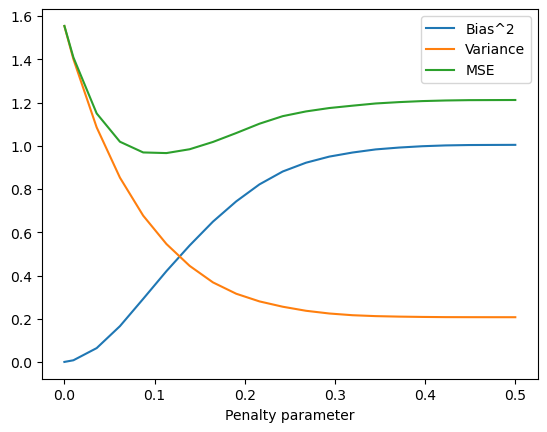

In [65]:
plt.plot(alphas, biases**2, label='Bias^2')
plt.plot(alphas, variances, label='Variance')
plt.plot(alphas, mses, label='MSE')
plt.xlabel('Penalty parameter')
plt.legend()
plt.show()

### The bias-variance trade-off curve

Look at the plot above:
- **At $\alpha = 0$ (OLS)**: Zero bias but highest variance
- **As $\alpha$ increases**: Bias increases (coefficients shrink away from truth), but variance decreases
- **Optimal $\alpha$**: MSE is minimized somewhere in between!

**Key insight:** A penalized regression with the right $\alpha$ outperforms the "true" unpenalized model! This is the bias-variance trade-off in action: we accept some bias to substantially reduce variance.

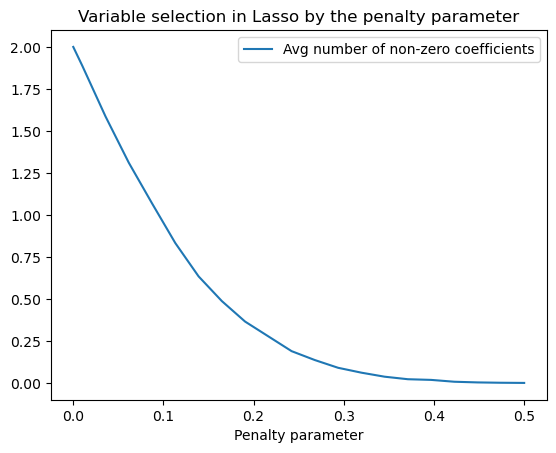

In [66]:
avg_num_coeffs = np.concatenate([[2], np.mean(lasso_n_coeffs, axis=0)])
plt.plot(alphas, avg_num_coeffs, label='Avg number of non-zero coefficients')
plt.xlabel('Penalty parameter')
plt.title('Variable selection in Lasso by the penalty parameter')
plt.legend()
plt.show()

## From simulation to practice: Cross-validation

In our simulation, we knew the true model and could compute bias and MSE directly. But in real ML:
- We don't know $f(X)$
- We can't generate unlimited data
- We need to estimate the optimal $\alpha$ from our single dataset

**Solution:** **Cross-validation**

The idea:
1. Split data into K folds
2. For each candidate $\alpha$, train on K-1 folds and evaluate on the held-out fold
3. Average performance across folds
4. Choose $\alpha$ with best cross-validated performance

This estimates MSE without knowing the true function, and will be a key technique throughout this course.

---

## Key takeaways

1. **Bias-variance trade-off**: More complex models have lower bias but higher variance
2. **Simple can beat complex**: When sample size is small or noise is high, stable (biased) models often outperform accurate (high-variance) ones
3. **Regularization helps**: Techniques like Lasso deliberately introduce bias to reduce variance
4. **Optimal complexity depends on data**: More data → can afford more complexity
5. **Cross-validation**: In practice, use CV to find the right balance